In [14]:
import torch 
import torchvision
from torchvision import transforms
from torch import nn,optim
from torch.utils.data import DataLoader,Dataset,Sampler
import glob 
import os 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

In [15]:
torch.manual_seed(1)
writer = SummaryWriter('classifier-1/runs')

In [16]:
from email.mime import image


torch.manual_seed(1)
class ShapeDataset(Dataset):
    def __init__(self,path ,dataset_type):
        
        """
        self.path contain the path of dataset 
        mode = 1 or 0 ( if mode is zero consider as train set else consider as val set )

        """
        self.path =  path
        self.Image_path_list = []
        self.classes = []

        self.dataset_type = dataset_type
        self.classlabel = {}
        label_no = 0
        for label in os.listdir(path):
            if os.path.isdir(path+label):
                self.classlabel[label] = label_no
                label_no+=1 
        for data_path in glob.glob(path+"**/*.png"):
            self.Image_path_list.append(data_path)
        
        np.random.shuffle(self.Image_path_list)

        if self.dataset_type:
            self.train = self.Image_path_list[:int(len(self.Image_path_list)*0.8)]
            
        else:
            self.test = self.Image_path_list[int(len(self.Image_path_list)*0.8):]

        


    def getImageAndLabel(self,data,index):
        img_path = data[index]
        label = torch.tensor(self.classlabel[img_path.split('/')[-2]])
        image = cv2.imread(img_path,0)
        # image = cv2.resize(image,interpolation=cv2.INTER_AREA)
        image = torch.from_numpy(image)/255.0
        # image = torch.cat(image,dim=0)
        # print(image.shape)
        return image,label

    def __getitem__(self,index):
        # print(index)
        if self.dataset_type :
            return self.getImageAndLabel(self.train,index)

        else:
            return self.getImageAndLabel(self.test,index)
            

    def __len__(self):
        if self.dataset_type:
            return len(self.train)

        else:
            return len(self.test)

In [17]:

class LinBNRelu(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.ln = nn.Linear(input_size,output_size)
        self.bn = nn.BatchNorm1d(num_features=output_size)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.ln(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [18]:


class ShapeClassifierNetwork(nn.Module):
   def __init__(self,input_size,output_size):
      super().__init__()
      self.input_layer = LinBNRelu(input_size,128)
      self.hidden1 =LinBNRelu(128,128)
      self.hidden2 =LinBNRelu(128,128)
      self.hidden3 =LinBNRelu(128,64)
      self.output_layer = nn.Linear(64,output_size)

   def forward(self,x):
      x = self.input_layer(x)
      x = self.hidden1(x)
      x = self.hidden2(x)
      x = self.hidden3(x)
      x = self.output_layer(x)

      return x 


In [19]:


# class ShapeClassifierNetwork(nn.Module):
#    def __init__(self,input_size,output_size):
#       super().__init__()
#       self.ln1 = nn.Linear(input_size, 128)
#       self.bn1 = nn.BatchNorm1d(num_features=128)
#       self.act1 = nn.ReLU()


#       self.ln2 = nn.Linear(128, 128)
#       self.bn2 = nn.BatchNorm1d(num_features=128)
#       self.act2 = nn.ReLU()


#       self.ln3 = nn.Linear(128, 128)
#       self.bn3 = nn.BatchNorm1d(num_features=128)
#       self.act3 = nn.ReLU()


#       self.ln4 = nn.Linear(128, 64)
#       self.bn4 = nn.BatchNorm1d(num_features=64)
#       self.act4 = nn.ReLU()

#       self.output = nn.Linear(64, output_size)


#    def forward(self,x):

#       x = self.ln1(x)
#       x = self.bn1(x)
#       x = self.act1(x)

#       x = self.ln2(x)
#       x = self.bn2(x)
#       x = self.act2(x)

#       x = self.ln3(x)
#       x = self.bn3(x)
#       x = self.act3(x)


#       x = self.ln4(x)
#       x = self.bn4(x)
#       x = self.act4(x)

#       x = self.output(x)

#       return x

In [20]:
def one_hot_encoded(y):
    num_classes=4
    y_onehot = torch.zeros(y.size(0),num_classes)
    y_onehot.scatter_(1, y.view(-1, 1).long(), 1).float()
    return y_onehot

In [21]:

def cross_entropy(input, target):
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(-target * logsoftmax(input), dim=1))



In [22]:

path="ImageData-2/shapes/"

In [23]:

train_dataset = ShapeDataset(path,1)
test_dataset = ShapeDataset(path,0)
# train_dataset[0]
train_dataset[0][0].shape
# len(train_dataset),len(test_dataset)


torch.Size([200, 200])

In [24]:

train_loader = DataLoader(dataset=train_dataset,batch_size=64,shuffle=True,num_workers=4)
test_loader = DataLoader(dataset=test_dataset,batch_size=64,shuffle=True,num_workers=4)

In [25]:

input_dim = 200 * 200
output_dim = 4

model = ShapeClassifierNetwork(input_dim,output_dim)
loss_func = nn.CrossEntropyLoss()
soft_max = torch.nn.Softmax()
optimizer = optim.SGD(model.parameters(),lr = 0.03)
print('W: ',list(model.parameters())[0].size())
# model.state_dict()['hidden.0.weight']
model

W:  torch.Size([128, 40000])


ShapeClassifierNetwork(
  (input_layer): LinBNRelu(
    (ln): Linear(in_features=40000, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (hidden1): LinBNRelu(
    (ln): Linear(in_features=128, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (hidden2): LinBNRelu(
    (ln): Linear(in_features=128, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (hidden3): LinBNRelu(
    (ln): Linear(in_features=128, out_features=64, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=4, bias=True)
)

In [26]:
# Tensorboard - Image and Graph Draw 
images, labels = next(iter(train_loader))
# print(images.shape,images.dtype)
img_grid = torchvision.utils.make_grid(images.unsqueeze(1))
writer.add_image('shape_images', img_grid)
writer.add_graph(model,images.view(-1,input_dim))


In [27]:
# Training

def train(model,train_loader,test_loader,optimizer,epochs=100):
    loss_list = []
    accuracyList = []
    test_loss_list = []
    for epoch in range(epochs):
        total_train_loss,toal_test_loss,correct,train_correct=0,0,0,0
        for x_train,y_train in train_loader:
            # print(x_train)
            model.train()
            z = model(x_train.view(-1,input_dim))
            optimizer.zero_grad()
            y_train = one_hot_encoded(y_train)
            loss = cross_entropy(z,y_train)
            
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()



        for x_test,y_test in test_loader:
            # print(x_test)
            model.eval()
            z_test = model(x_test.view(-1,input_dim))
           
            y_enc = one_hot_encoded(y_test)
            test_loss = cross_entropy(z_test,y_enc)
            
            _,z_test_yhat = torch.max(z_test,1)
            correct += (y_test==z_test_yhat).sum().item()
            toal_test_loss += test_loss
        val_accuracy = (correct / len(test_dataset)) * 100
        
        if epoch%10==0:
            print(f'Epoch {epoch+0:03}: | Train Loss: {total_train_loss:.3f} | Test Loss:{toal_test_loss:.3f} | Val accuracy: {val_accuracy:.5f}')
        loss_list.append(total_train_loss)
        accuracyList.append(val_accuracy)

        writer.add_scalar(f"Train/Train-loss",total_train_loss,epoch)
        writer.add_scalar(f"Acc/Accuracy",val_accuracy,epoch)
        writer.add_scalar(f"Train/Test-loss",toal_test_loss,epoch)
    plt.plot(range(epochs),loss_list,label="loss")
    plt.plot(range(epochs),accuracyList,label="accuracy")
    plt.legend()
    writer.close()
    return model 


In [28]:
# train(model,train_loader,test_loader,optimizer,epochs=400)

/tmp/ipykernel_593530/2946925598.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.mean(torch.sum(-target * logsoftmax(input), dim=1))


Epoch 000: | Train Loss: 17.664 | Test Loss:7.778 | Val accuracy: 91.85037
Epoch 010: | Train Loss: 0.912 | Test Loss:55.886 | Val accuracy: 73.01269
Epoch 020: | Train Loss: 0.191 | Test Loss:0.020 | Val accuracy: 100.00000
Epoch 030: | Train Loss: 0.744 | Test Loss:18.138 | Val accuracy: 90.81496
Epoch 040: | Train Loss: 0.263 | Test Loss:0.021 | Val accuracy: 100.00000
Epoch 050: | Train Loss: 0.726 | Test Loss:0.016 | Val accuracy: 100.00000
Epoch 060: | Train Loss: 0.072 | Test Loss:0.006 | Val accuracy: 100.00000
Epoch 070: | Train Loss: 0.228 | Test Loss:0.009 | Val accuracy: 100.00000
Epoch 080: | Train Loss: 0.448 | Test Loss:44.951 | Val accuracy: 87.44155
Epoch 090: | Train Loss: 0.079 | Test Loss:0.008 | Val accuracy: 100.00000
Epoch 100: | Train Loss: 0.066 | Test Loss:0.006 | Val accuracy: 100.00000
Epoch 110: | Train Loss: 0.095 | Test Loss:0.005 | Val accuracy: 100.00000
Epoch 120: | Train Loss: 0.671 | Test Loss:0.276 | Val accuracy: 99.83300
Epoch 130: | Train Loss: 0

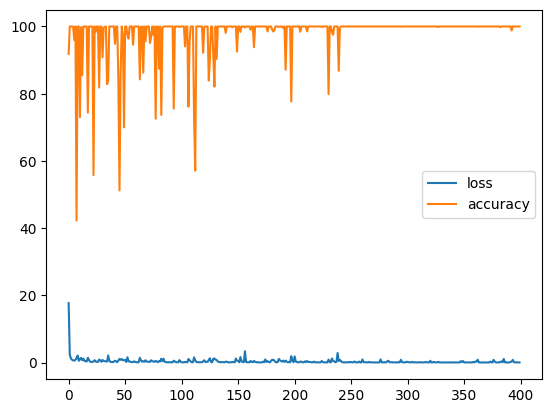

In [29]:

PATH = "ShapeModels-1/model-weights.pth"
trained_model = train(model,train_loader,test_loader,optimizer,epochs=400)
torch.save(trained_model,PATH)
torch.save(trained_model.state_dict(), PATH)
# predict(trained_model,test_loader)

In [30]:
# for x_test,y_test in test_loader:
#     # print(x_test)
#     model.eval()
#     z_test = model(x_test.view(-1,28*28))
    
#     y_enc = one_hot_encoded(y_test)
#     test_loss = cross_entropy(z_test,y_enc)
    
#     _,z_yhat = torch.max(z_test,1)
#     break
#     # correct += (y_test==z_yhat).sum().item()
#     # toal_test_loss += test_loss

In [31]:
# y_test

In [32]:
# z_yhat

In [33]:
# z_test.shape

In [34]:
# F.softmax(z_test[0],0)

In [35]:

def get_modle():
    model = torch.load("/home/local/ZOHOCORP/kala-pt5650/programs/Neural-Network/pytorch/ImageClassifier/test_/shape_classifier.pth")
    model.eval()
    return model

In [36]:

# def soft_max_func(z):
#     return torch.exp(z)/(torch.sum((torch.exp(z)),axis=1).view(-1,1))


In [37]:



# def cross_entropy(y_pred,y):
#     log_prob = torch.log(y_pred)
#     # y = one_hot_encoded(y)
#     cost = - torch.mean(log_prob*y)
#     return cost

In [38]:
# def cross_entropy(y_pred,y):
#     loss = -torch.mean(torch.log(y_pred[range(len(y)), y]))
#     return loss

In [39]:
# writer.add_graph(model, images)
# writer.close()

In [40]:
# def cross_entropy(y_pred,y):
#     return -1 * torch.sum((y*torch.log(y_pred)) + (1-y) * torch.log(1-y_pred))


In [41]:
# images.unsqueeze(1).shape

In [42]:
# g = torchvision.utils.make_grid(images.unsqueeze(1), nrow=2, padding=2)

In [43]:
# plt.imshow(g.numpy().transpose(1,2,0))

In [44]:
# a = np.arange(0,36,dtype=np.uint8).reshape(6,6)
# kernel = np.ones((3,3),np.uint8)
# gradient = cv2.morphologyEx(a, cv2.MORPH_GRADIENT, kernel)
# a,gradient